## Tweet Model

In [141]:
import sklearn
import pandas as pd
import numpy as np
#from textblob import TextBlob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Data Pre-Processing

In [142]:
with open('full_tweets.csv') as f:
    tweets = pd.read_csv(f)
tweets['timestamp'] = pd.to_datetime(tweets['date'] + ' ' + tweets['time'])
tweets.set_index('timestamp', inplace = True)
tweets.sort_index(inplace =True)
tweets = tweets.drop_duplicates(['id', 'tweet'])
start_date= '2019-04-17 12:00'
end_date = '2019-09-18 12:00'
num_weeks = int((pd.to_datetime(end_date) - pd.to_datetime(start_date)).days/7.0)
data = tweets.loc[start_date: end_date]
week_strings = [[(pd.to_datetime(start_date) +pd.Timedelta(str(7*n) + ' days')).strftime('%Y-%m-%d'),(pd.to_datetime(start_date) +pd.Timedelta(str(7*(n+1)) + ' days')).strftime('%Y-%m-%d')] for n in range(num_weeks)]
weeks = [data.loc[pd.to_datetime(start_date) +pd.Timedelta(str(7*n) + ' days'):pd.to_datetime(start_date) +pd.Timedelta(str(7*(n+1)) + ' days')] for n in range(num_weeks)]
for i in range(len(weeks)):
    weeks[i]['completion'] = (weeks[i].index - weeks[i].index[0])/pd.Timedelta('7 days')

####  Pre-processing helper functions

In [143]:
def get_at_time(df, num_3):
    num_3 = int(min(num_3,55))+1
    return df.loc[df.index[0]:df.index[0]+pd.Timedelta(str(num_3*3)+'h')]
def get_features(df, num_3):
    label = int(df.count()[0])
    df = get_at_time(df, num_3)
    df['likes_count_ema'] = df.likes_count.ewm(span = 1000).mean()
    df['retweets_count_ema'] = df.retweets_count.ewm(span = 1000).mean()
    df = df[['completion', 'likes_count_ema', 'retweets_count_ema']]
    df['count'] = int(df.count()[0])
    df['settle'] = label
    return df.iloc[-1]
def get_as_df(weeks, leave_off):
    leave_off = min(leave_off, len(weeks) -2)
    X_1 = []
    for i in range(len(weeks)-leave_off):
        for j in range(56):
            X_1.extend(get_features(weeks[i],j).to_numpy())

    features = get_features(weeks[i],j).index
    X = np.array(X_1).reshape(-1,len(features))
    X_1 = []
    for i in range(len(weeks)-leave_off, len(weeks)):
        for j in range(56):
            X_1.extend(get_features(weeks[i],j).to_numpy())    
    X_2 = np.array(X_1).reshape(-1,len(features))
    return pd.DataFrame(X, columns = features), pd.DataFrame(X_2, columns = features)
def get_week_df(weeks, specific_week):
    specific_week = min(specific_week, len(weeks)-1)
    X_1 = []
    for j in range(56):
        X_1.extend(get_features(weeks[specific_week],j).to_numpy())

    features = get_features(weeks[i],j).index
    X = np.array(X_1).reshape(-1,len(features))

    return pd.DataFrame(X, columns = features)


### Model Training

In [147]:
from sklearn.ensemble import RandomForestRegressor
leave_off = 10
train_data, test_data = get_as_df(weeks,leave_off)
X_train, X_test , y_train, y_test = train_data.drop(['settle'], axis = 'columns'), test_data.drop(['settle'], axis = 'columns'), train_data.settle, test_data.settle, 
model = RandomForestRegressor(n_estimators = 100)
model.fit(X_train,y_train)
#model.score(X_test, y_test)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

### Plots of prediction error for every week throughout week
Test data have 'TEST_DATA' written before them.  
The last two plots are average error for the given weeks.

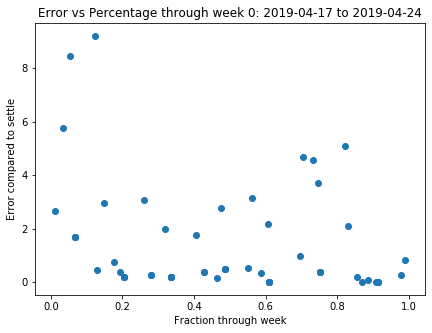

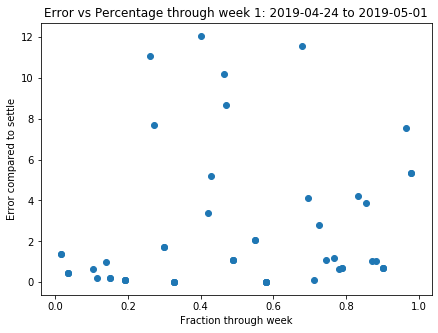

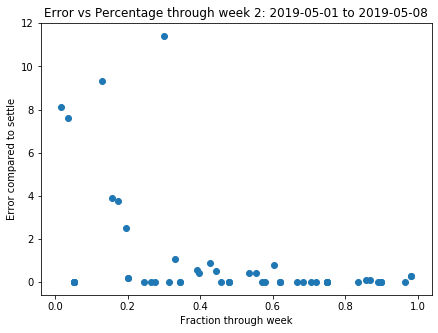

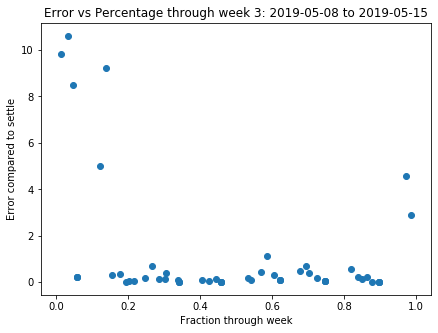

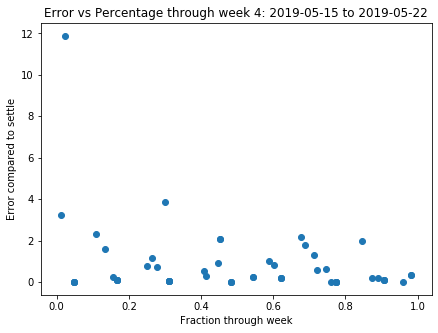

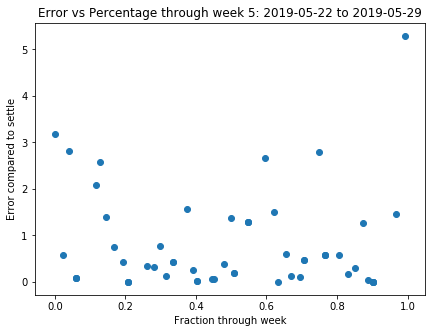

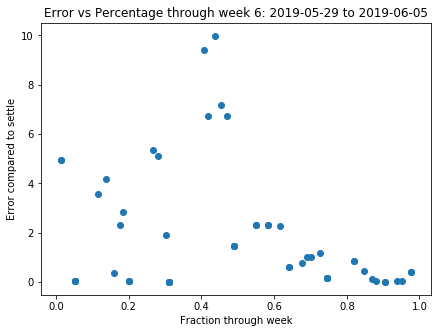

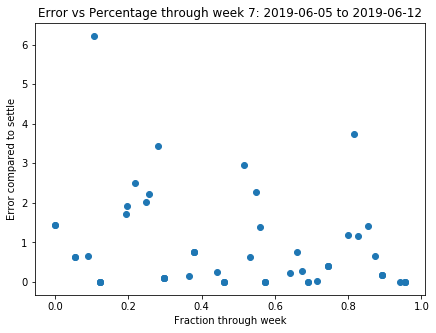

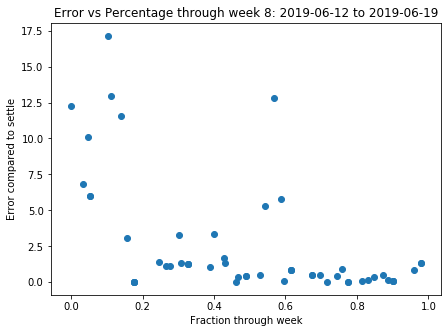

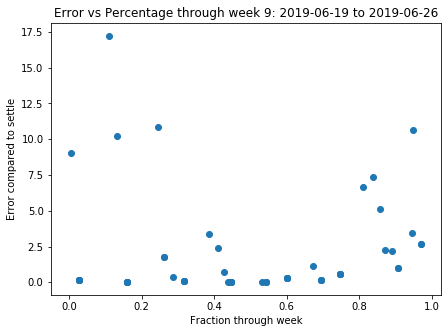

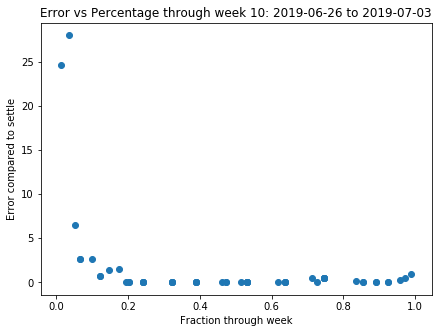

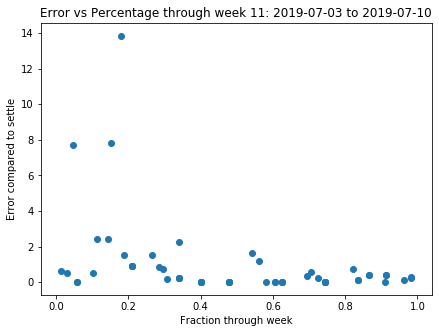

TEST_DATA


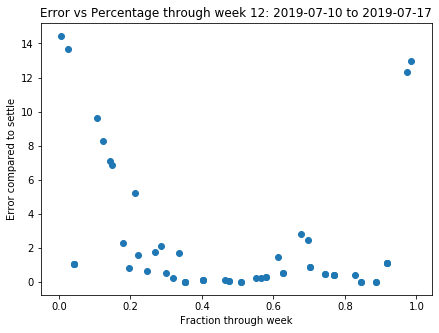

TEST_DATA


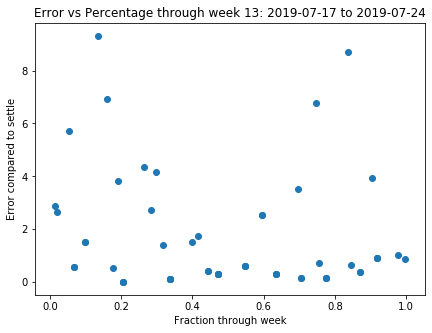

TEST_DATA


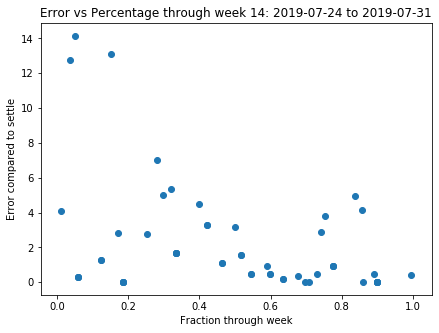

TEST_DATA


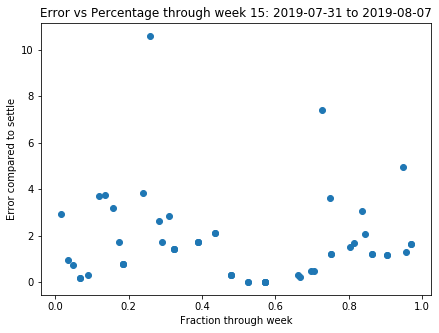

TEST_DATA


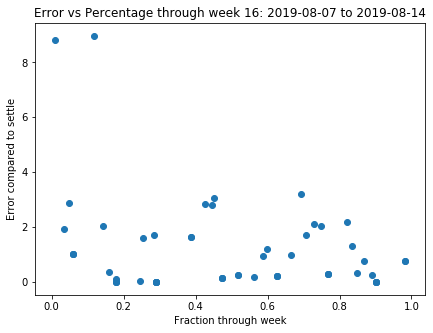

TEST_DATA


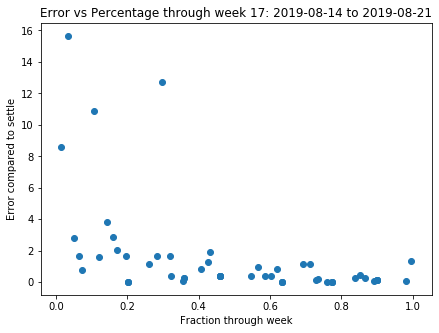

TEST_DATA


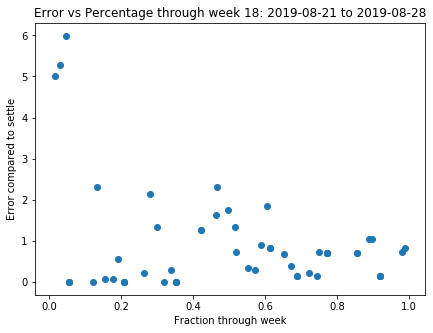

TEST_DATA


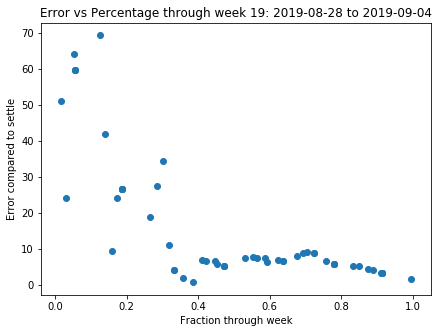

TEST_DATA


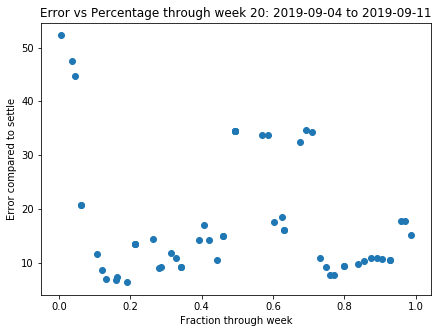

TEST_DATA


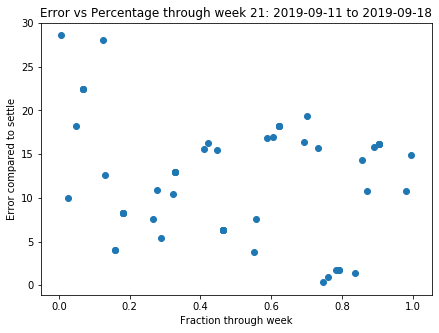

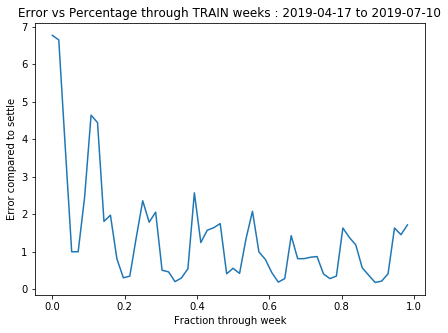

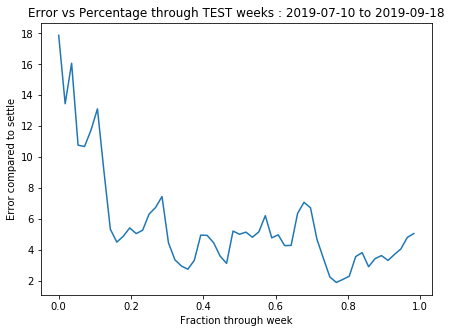

In [145]:
test = np.zeros(56)
train = np.zeros(56)
test_num, train_num = 0, 0 
for i in range(len(weeks)):

    df = get_week_df(weeks,i)
    fig = plt.figure(figsize = [7,5])
    ax = fig.add_subplot(111)
    error = (model2.predict(df.drop(['settle'], axis = 'columns')) - df.settle).abs().to_numpy()    
    if (i >= (len(weeks)-leave_off)):
        print('TEST_DATA')
        test_num+=1
        test += error
    else:
        train +=error
        train_num+=1
    ax.scatter(df.completion.to_numpy(),(model2.predict(df.drop(['settle'], axis = 'columns')) - df.settle).abs().to_numpy())
    ax.set_title('Error vs Percentage through week ' + str(i) + ': ' + week_strings[i][0]+ ' to ' + week_strings[i][1])
    ax.set_xlabel('Fraction through week')
    ax.set_ylabel('Error compared to settle')
    plt.show()
fig = plt.figure(figsize = [7,5])
ax = fig.add_subplot(111)
ax.plot(np.array(range(56))/56,train/train_num)
ax.set_title('Error vs Percentage through TRAIN weeks : ' + week_strings[0][0]+ ' to ' + week_strings[len(weeks)-leave_off-1][1])
ax.set_xlabel('Fraction through week')
ax.set_ylabel('Error compared to settle')
plt.show()

fig = plt.figure(figsize = [7,5])
ax = fig.add_subplot(111)
ax.plot(np.array(range(56))/56,test/test_num)
ax.set_title('Error vs Percentage through TEST weeks : ' + week_strings[len(weeks)-leave_off-1][1]+ ' to ' + week_strings[-1][1])
ax.set_xlabel('Fraction through week')
ax.set_ylabel('Error compared to settle')
plt.show()

### Pseudo Cross Validation
Leave off 6-15 weeks out fo 20 for test data and train on rest. Do score based on estimations from 60%-100% finished the week.

In [146]:
for leave_off in range ( 6, len(weeks)-5):
    train_data, test_data = get_as_df(weeks,leave_off)
    model = RandomForestRegressor(n_estimators = 100)
    model.fit(train_data.drop(['settle'], axis = 'columns'), train_data.settle)
    test_data = test_data[(test_data['completion'] > 0.6) & (test_data['completion'] < 1)]
    print(model.score(test_data.drop(['settle'], axis = 'columns'), test_data.settle))

0.5751562250939137
0.7409016770157075
0.6467479314048155
0.41424961689182793
0.3403642296217676
0.31969405888957436
0.5112205935795375
0.6178148878154515
0.6025827494619469
0.6054929811517651
0.612734627614608
